In [89]:
import pandas as pd
from utility_functions import cross_validate_and_save_model, vectorize, evaluate,get_confused_samples
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import random
plt.style.use('dark_background')

# Modify Data
create a modified version of the data that is more balanced and has less samples that are tagged as "no topic"

In [90]:
df = pd.read_csv(f'../data/6 - Classification data/full_classification_df.csv')

df.dropna(subset=['NonStopwordsQuoteText'],inplace=True)
print("total number of samples:",df.shape[0])
print(df['Tag'].value_counts())

total number of samples: 2367
בלי           1035
חינוך          214
קורונה         211
רווחה          191
כלכלי          186
נשים           168
בריאות         161
בטחון פנים     102
בטחון           99
Name: Tag, dtype: int64


In [91]:
df = df.sort_values(by=['Tag']).reset_index(drop=True)
first = df['Tag'].gt("בלי").idxmax()
no_topic_lst = df.index[df['Tag']=="בלי"].tolist()

# drop most samples that are tagged as "no topic" (leave only 200)
first, last = no_topic_lst[0], no_topic_lst[-1]
keep_range = random.sample(range(first, last), 200)
keep_range.extend(range(0,first))
keep_range.extend(range(last + 1, len(df)))

df = df.iloc[keep_range].reset_index(drop=True)
print(df['Tag'].value_counts())
print("total number of samples:",df.shape[0])
df = df.sample(frac=1).reset_index(drop=True)
df.head()

חינוך         214
קורונה        211
בלי           200
רווחה         191
כלכלי         186
נשים          168
בריאות        161
בטחון פנים    102
בטחון          99
Name: Tag, dtype: int64
total number of samples: 1532


,Type,QuoteWordCount,QuoteLen,StartDate,Speaker,QuoteText,NonStopwordsQuoteText,Tag
0,Committee,67.0,394.0,2020-11-11 22:25:00,"<< יור >> היו""ר איתן גינזבורג: << יור >>","אפשר להתחיל? חבריי חברי הכנסת, אני מתכבד לפתוח...",להתחיל חבריי ישיבתה רביעי כד בחשוון התשפא ה-11...,קורונה
1,Committee,41.0,275.0,2018-02-26 10:30:00,"היו""ר איתן כבל:","גברתי מנהלת הוועדה, היועצת המשפטית, היועצות המ...",היועצת המשפטית היועצות המשפטיות רשמת פרלמנטרית...,כלכלי
2,Committee,125.0,672.0,2017-06-07 09:30:00,"היו""ר יעקב מרגי:",הלוואי והייתי יכול לעצור את מה שההורים נאלצים ...,הלוואי והייתי לעצור שההורים נאלצים הרב ההכרח י...,חינוך
3,Committee,23.0,132.0,2018-02-05 11:45:00,"היו""ר עאידה תומא סלימאן:",אני פותחת את הישיבה של הוועדה לקידום מעמד האיש...,פותחת לקידום מעמד האישה ולשוויון מגדרי ממשיכות...,נשים
4,Committee,60.0,371.0,2021-12-16 10:00:00,"<< יור >> היו""ר גלעד קריב: << יור >>",אנחנו נמצאים עם ארבע תחיקות על שולחננו. הראשונ...,ארבע תחיקות שולחננו הראשונה עוסקת בהגבלת היציא...,קורונה


## Split data to train and test

In [92]:
X = df['NonStopwordsQuoteText']
y = df['Tag']
names = ["X_train", "X_test", "y_train", "y_test"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for name, data in enumerate([X_train, X_test, y_train, y_test]):
    data.reset_index(drop=True, inplace=True)
    data.to_csv(f'../data/7 - Classification Data (phase 2)/{names[name]}.csv', index=0)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

print("Tags distribution:\n")
print("train tags\n", y_train.value_counts(), "\n")
print("test tags\n", y_test.value_counts())

Tags distribution:

train tags
 קורונה        178
בלי           168
חינוך         166
רווחה         143
כלכלי         141
נשים          138
בריאות        131
בטחון פנים     80
בטחון          80
Name: Tag, dtype: int64 

test tags
 חינוך         48
רווחה         48
כלכלי         45
קורונה        33
בלי           32
נשים          30
בריאות        30
בטחון פנים    22
בטחון         19
Name: Tag, dtype: int64


## Vectorize data

In [93]:
X_train_counts, X_test_counts = vectorize(X_train, X_test,"simple_counts")
X_train_tfidf, X_test_tfidf = vectorize(X_train, X_test,"tfidf")

simple counts: 1225 quotes, 48856 words in train set
TFIDF: 1225 quotes, 48856 words in train set


# Classificaiton models
## Logistic Regression
#### Logistic Regression with simple counts

In [94]:
logistic_simple_model, logistic_simple_predicted = cross_validate_and_save_model(LogisticRegression(), X_train_counts, y_train, X_test_counts, kf, scoring, 'logistic_simple_counts',2)

cross validation scores (5fold) for logistic_simple_counts:
accuracy: 0.5395918367346939
precision_macro: 0.6627291315362172
recall_macro: 0.4955366836224794
f1_macro: 0.5190175117776417


In [95]:
logistic_c2_simple_model, logistic_c2_simple_predicted = cross_validate_and_save_model(LogisticRegression(C=2), X_train_counts, y_train, X_test_counts, kf, scoring, 'logistic_c2_simple_counts',2)

cross validation scores (5fold) for logistic_c2_simple_counts:
accuracy: 0.5428571428571429
precision_macro: 0.6732708978349139
recall_macro: 0.5000964840646329
f1_macro: 0.5253560295401044


In [96]:
logistic_c05_simple_model, logistic_c05_simple_predicted = cross_validate_and_save_model(LogisticRegression(C=0.5), X_train_counts, y_train, X_test_counts, kf, scoring, 'logistic_c05_simple_counts',2)

cross validation scores (5fold) for logistic_c05_simple_counts:
accuracy: 0.5363265306122449
precision_macro: 0.6600821477648704
recall_macro: 0.49185176410518006
f1_macro: 0.5158436768887148


#### Logistic Regression with TFIDF

In [97]:
logistic_tfidf_model, logistic_tfidf_predicted = cross_validate_and_save_model(LogisticRegression(), X_train_tfidf, y_train, X_test_tfidf, kf, scoring, 'logistic_tfidf_counts',2)

cross validation scores (5fold) for logistic_tfidf_counts:
accuracy: 0.5028571428571429
precision_macro: 0.6132576550207339
recall_macro: 0.4489704647029484
f1_macro: 0.46084566755209816


In [98]:
logistic_c05_tfidf_model, logistic_c05_tfidf_predicted = cross_validate_and_save_model(LogisticRegression(C=0.5), X_train_tfidf, y_train, X_test_tfidf, kf, scoring, 'logistic_c05_tfidf_counts',2)

cross validation scores (5fold) for logistic_c05_tfidf_counts:
accuracy: 0.4783673469387756
precision_macro: 0.5859921233270375
recall_macro: 0.42044538660156705
f1_macro: 0.4334592090696289


## Random Forest
#### Random forest with simple counts

In [99]:
forest_30_100_simple_model, forest_30_100_simple_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=30, max_depth=100), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_30_100_simple_counts',2)

cross validation scores (5fold) for forest_30_100_simple_counts:
accuracy: 0.5428571428571429
precision_macro: 0.6496841971119537
recall_macro: 0.49815620579184944
f1_macro: 0.5117776495450286


In [100]:
forest_100_100_simple_model, forest_100_100_simple_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=100, max_depth=100), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_100_100_simple_counts',2)

cross validation scores (5fold) for forest_100_100_simple_counts:
accuracy: 0.5502040816326531
precision_macro: 0.6763294577781659
recall_macro: 0.5120271477810137
f1_macro: 0.5341769066627966


In [101]:
forest_200_100_simple_model, forest_200_100_simple_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=200, max_depth=100), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_200_100_simple_counts',2)

cross validation scores (5fold) for forest_200_100_simple_counts:
accuracy: 0.5542857142857143
precision_macro: 0.6920818528757252
recall_macro: 0.5184348970459866
f1_macro: 0.5422409001932406


In [102]:
forest_100_200_simple_model, forest_100_200_simple_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=100, max_depth=200), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_100_200_simple_counts',2)

cross validation scores (5fold) for forest_100_200_simple_counts:
accuracy: 0.5314285714285715
precision_macro: 0.7053701660260485
recall_macro: 0.4918231976203364
f1_macro: 0.5146651124643044


In [103]:
forest_100_1000_simple_model, forest_100_1000_simple_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=100, max_depth=1000), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_100_1000_simple_counts',2)

cross validation scores (5fold) for forest_100_1000_simple_counts:
accuracy: 0.5134693877551021
precision_macro: 0.7314474205122474
recall_macro: 0.46671871145047134
f1_macro: 0.48613571944527517


In [104]:
forest_150_1000_simple_model, forest_150_1000_simple_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=150, max_depth=1000), X_train_counts, y_train, X_test_counts, kf, scoring, 'forest_150_1000_simple_counts',2)

cross validation scores (5fold) for forest_150_1000_simple_counts:
accuracy: 0.5093877551020408
precision_macro: 0.7291586662522715
recall_macro: 0.46129962058646024
f1_macro: 0.48100932327777635


#### Random forest with TFIDF

In [105]:
forest_100_200_tfidf_model, forest_100_200_tfidf_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=100, max_depth=200), X_train_tfidf, y_train, X_test_tfidf, kf, scoring, 'forest_100_200_tfidf_counts',2)

cross validation scores (5fold) for forest_100_200_tfidf_counts:
accuracy: 0.5404081632653062
precision_macro: 0.7192848489343585
recall_macro: 0.5033159276035647
f1_macro: 0.5320029409417708


In [106]:
forest_100_1000_tfidf_model, forest_100_1000_tfidf_predicted = cross_validate_and_save_model(RandomForestClassifier(n_estimators=100, max_depth=1000), X_train_tfidf, y_train, X_test_tfidf, kf, scoring, 'forest_100_1000_tfidf_counts',2)

cross validation scores (5fold) for forest_100_1000_tfidf_counts:
accuracy: 0.5110204081632654
precision_macro: 0.7311219989334303
recall_macro: 0.4642240798299084
f1_macro: 0.48544855644485646


## SVM
#### SVM with simple counts

In [107]:
svm_simple_model, svm_simple_predicted = cross_validate_and_save_model(svm.SVC(), X_train_counts, y_train, X_test_counts, kf, scoring, 'svm_simple_counts',2)

cross validation scores (5fold) for svm_simple_counts:
accuracy: 0.42122448979591837
precision_macro: 0.5725597875050338
recall_macro: 0.37429113088863597
f1_macro: 0.3745707596923427


#### SVM with TFIDF

In [108]:
svm_tfidf_model, svm_tfidf_predicted = cross_validate_and_save_model(svm.SVC(), X_train_tfidf, y_train, X_test_tfidf, kf, scoring, 'svm_tfidf_counts',2)

cross validation scores (5fold) for svm_tfidf_counts:
accuracy: 0.4073469387755102
precision_macro: 0.6761267020178908
recall_macro: 0.3537858837591105
f1_macro: 0.36954101587277033


# Evaluation

In [109]:
quotes = X_test.reset_index()
quotes['true'] = y_test
mat_tags = ['בטחון','בטחון פנים','בלי','בריאות','חינוך','כלכלי','נשים','קורונה','רווחה']
quotes

,index,NonStopwordsQuoteText,true
0,0,שאמר היושב-ראש הפגרה והעובדה שהרבה ונוכח המגמה...,בלי
1,1,הפיקוח שירותים פיננסיים שירותים פיננסיים מוסדר...,כלכלי
2,2,כשאני מסתכל הכסף שמגיע עבור חייל בודד סיבה תשכ...,בטחון
3,3,החינוך התרבות והספורט ישיבה משותפת החינוך התרב...,חינוך
4,4,המוסדות המטרה להגן עובדי רווחה שרשום מספק שירו...,רווחה
...,...,...,...
302,302,מדינת מדינה שנמצאת תחת איום מהקשים והכבדים שיכ...,בטחון
303,303,אתחיל במערכת החינוך בסך הכול תלמידי החינוך החר...,חינוך
304,304,התנהלות ימים וביקשתי מירדנה לפנות למזכיר העברו...,בלי
305,305,החוקה ומשפט 15 במרץ ממשיכים חדלות פירעון ושיקו...,כלכלי


## Logistic regression

-------Logistic Regression simple counts, C=1) Evaluation-------
Micro:
precision: 0.5374592833876222
recall: 0.5374592833876222
f1: 0.5374592833876222

Macro:
precision: 0.7672054979620769
recall: 0.5152246145667199
f1: 0.562500754937829

Accuracy: 0.5374592833876222

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 106 of 142 (74.64788732394366%)

Distribution of misclassified topics:
בלי       106
בריאות      9
כלכלי       9
רווחה       8
חינוך       7
קורונה      2
נשים        1
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
4,4,המוסדות המטרה להגן עובדי רווחה שרשום מספק שירו...,רווחה,בלי
7,7,המשך מעקב הפסקת תקצוב וסגירת תוכניות ההכשרה למ...,חינוך,בלי
8,8,זימנתי המלג מתמרצים מעודדים סטודנטים ללימודי פ...,חינוך,בלי
9,9,סוד הולכים ומדברים ויותר הצורך בתקופה לשמור או...,קורונה,בריאות
10,10,החלק החזרת מהעודפים ממשרד האוצר נדון שדנו מבקר...,כלכלי,בלי
...,...,...,...,...
299,299,נוסף שהגיע לפתחה שאנשים שחלו בקורונה בישראל פג...,קורונה,בלי
300,300,במהלך הקיץ בחודשיים-שלושה האחרונים ארבעה נפגעו...,בטחון פנים,בלי
302,302,מדינת מדינה שנמצאת תחת איום מהקשים והכבדים שיכ...,בטחון,כלכלי
304,304,התנהלות ימים וביקשתי מירדנה לפנות למזכיר העברו...,בלי,כלכלי


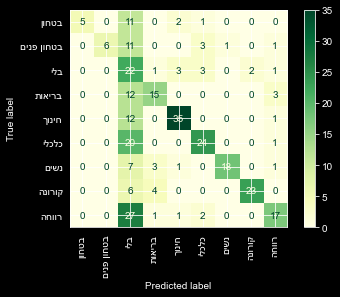

In [110]:
evaluate("-------Logistic Regression simple counts, C=1) Evaluation-------",y_test,logistic_simple_predicted,mat_tags)
get_confused_samples(quotes,logistic_simple_predicted)

-------Logistic Regression simple counts, C=2) Evaluation-------
Micro:
precision: 0.5407166123778502
recall: 0.5407166123778502
f1: 0.5407166123778502

Macro:
precision: 0.7685695570507972
recall: 0.517693750369189
f1: 0.5645922634758783

Accuracy: 0.5407166123778502

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 105 of 141 (74.46808510638297%)

Distribution of misclassified topics:
בלי       105
בריאות      9
רווחה       8
חינוך       8
כלכלי       8
קורונה      2
נשים        1
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
4,4,המוסדות המטרה להגן עובדי רווחה שרשום מספק שירו...,רווחה,בלי
7,7,המשך מעקב הפסקת תקצוב וסגירת תוכניות ההכשרה למ...,חינוך,בלי
8,8,זימנתי המלג מתמרצים מעודדים סטודנטים ללימודי פ...,חינוך,בלי
9,9,סוד הולכים ומדברים ויותר הצורך בתקופה לשמור או...,קורונה,בריאות
10,10,החלק החזרת מהעודפים ממשרד האוצר נדון שדנו מבקר...,כלכלי,בלי
...,...,...,...,...
299,299,נוסף שהגיע לפתחה שאנשים שחלו בקורונה בישראל פג...,קורונה,בלי
300,300,במהלך הקיץ בחודשיים-שלושה האחרונים ארבעה נפגעו...,בטחון פנים,בלי
302,302,מדינת מדינה שנמצאת תחת איום מהקשים והכבדים שיכ...,בטחון,כלכלי
304,304,התנהלות ימים וביקשתי מירדנה לפנות למזכיר העברו...,בלי,כלכלי


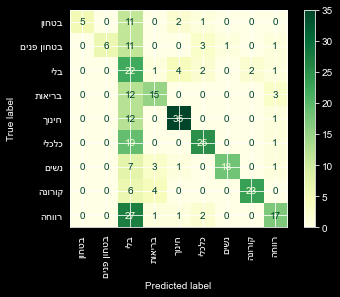

In [111]:
evaluate("-------Logistic Regression simple counts, C=2) Evaluation-------",y_test,logistic_c2_simple_predicted,mat_tags)
get_confused_samples(quotes,logistic_c2_simple_predicted)

In [147]:
print(classification_report(y_test,logistic_c2_simple_predicted,target_names=mat_tags))

              precision    recall  f1-score   support

       בטחון       1.00      0.26      0.42        19
  בטחון פנים       1.00      0.27      0.43        22
         בלי       0.17      0.69      0.28        32
      בריאות       0.62      0.50      0.56        30
       חינוך       0.81      0.73      0.77        48
       כלכלי       0.76      0.56      0.64        45
        נשים       0.95      0.60      0.73        30
      קורונה       0.92      0.70      0.79        33
       רווחה       0.68      0.35      0.47        48

    accuracy                           0.54       307
   macro avg       0.77      0.52      0.56       307
weighted avg       0.75      0.54      0.58       307



-------Logistic Regression simple counts, C=0.5) Evaluation-------
Micro:
precision: 0.5374592833876222
recall: 0.5374592833876222
f1: 0.5374592833876222

Macro:
precision: 0.7702070457796438
recall: 0.5146494181581901
f1: 0.5575390023835902

Accuracy: 0.5374592833876222

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 107 of 142 (75.35211267605634%)

Distribution of misclassified topics:
בלי       107
רווחה       9
בריאות      8
כלכלי       8
חינוך       7
קורונה      2
נשים        1
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
4,4,המוסדות המטרה להגן עובדי רווחה שרשום מספק שירו...,רווחה,בלי
7,7,המשך מעקב הפסקת תקצוב וסגירת תוכניות ההכשרה למ...,חינוך,בלי
8,8,זימנתי המלג מתמרצים מעודדים סטודנטים ללימודי פ...,חינוך,בלי
9,9,סוד הולכים ומדברים ויותר הצורך בתקופה לשמור או...,קורונה,בריאות
10,10,החלק החזרת מהעודפים ממשרד האוצר נדון שדנו מבקר...,כלכלי,בלי
...,...,...,...,...
299,299,נוסף שהגיע לפתחה שאנשים שחלו בקורונה בישראל פג...,קורונה,בלי
300,300,במהלך הקיץ בחודשיים-שלושה האחרונים ארבעה נפגעו...,בטחון פנים,בלי
302,302,מדינת מדינה שנמצאת תחת איום מהקשים והכבדים שיכ...,בטחון,כלכלי
304,304,התנהלות ימים וביקשתי מירדנה לפנות למזכיר העברו...,בלי,כלכלי


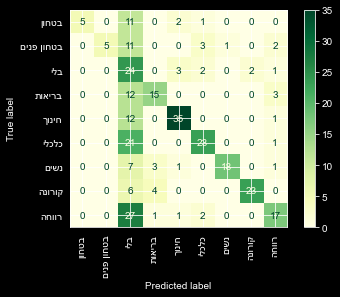

In [112]:
evaluate("-------Logistic Regression simple counts, C=0.5) Evaluation-------",y_test,logistic_c05_simple_predicted,mat_tags)
get_confused_samples(quotes,logistic_c05_simple_predicted)

-------Logistic Regression TFIDF counts, C=1) Evaluation-------
Micro:
precision: 0.5504885993485342
recall: 0.5504885993485342
f1: 0.5504885993485342

Macro:
precision: 0.7486303811833708
recall: 0.5186802232854864
f1: 0.5475440037922802

Accuracy: 0.5504885993485342

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 89 of 138 (64.4927536231884%)

Distribution of misclassified topics:
בלי       89
רווחה     20
בריאות    10
חינוך      7
קורונה     5
כלכלי      5
נשים       2
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
0,0,שאמר היושב-ראש הפגרה והעובדה שהרבה ונוכח המגמה...,בלי,רווחה
2,2,כשאני מסתכל הכסף שמגיע עבור חייל בודד סיבה תשכ...,בטחון,בלי
7,7,המשך מעקב הפסקת תקצוב וסגירת תוכניות ההכשרה למ...,חינוך,בלי
8,8,זימנתי המלג מתמרצים מעודדים סטודנטים ללימודי פ...,חינוך,רווחה
9,9,סוד הולכים ומדברים ויותר הצורך בתקופה לשמור או...,קורונה,בריאות
...,...,...,...,...
299,299,נוסף שהגיע לפתחה שאנשים שחלו בקורונה בישראל פג...,קורונה,בלי
300,300,במהלך הקיץ בחודשיים-שלושה האחרונים ארבעה נפגעו...,בטחון פנים,בלי
302,302,מדינת מדינה שנמצאת תחת איום מהקשים והכבדים שיכ...,בטחון,בלי
304,304,התנהלות ימים וביקשתי מירדנה לפנות למזכיר העברו...,בלי,כלכלי


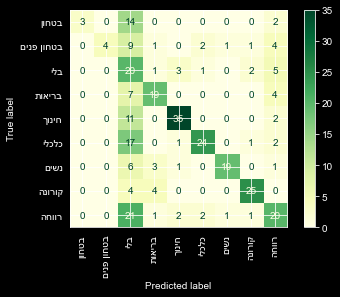

In [113]:
evaluate("-------Logistic Regression TFIDF counts, C=1) Evaluation-------",y_test,logistic_tfidf_predicted,mat_tags)
get_confused_samples(quotes,logistic_tfidf_predicted)

-------Logistic Regression TFIDF counts, C=0.5) Evaluation-------
Micro:
precision: 0.501628664495114
recall: 0.501628664495114
f1: 0.501628664495114

Macro:
precision: 0.5411965058895253
recall: 0.4592031425364758
f1: 0.46687670494019035

Accuracy: 0.501628664495114

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 118 of 153 (77.12418300653596%)

Distribution of misclassified topics:
בלי       118
רווחה       8
בריאות      8
כלכלי       6
חינוך       6
קורונה      5
נשים        2
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
0,0,שאמר היושב-ראש הפגרה והעובדה שהרבה ונוכח המגמה...,בלי,רווחה
2,2,כשאני מסתכל הכסף שמגיע עבור חייל בודד סיבה תשכ...,בטחון,בלי
7,7,המשך מעקב הפסקת תקצוב וסגירת תוכניות ההכשרה למ...,חינוך,בלי
8,8,זימנתי המלג מתמרצים מעודדים סטודנטים ללימודי פ...,חינוך,בלי
9,9,סוד הולכים ומדברים ויותר הצורך בתקופה לשמור או...,קורונה,בריאות
...,...,...,...,...
299,299,נוסף שהגיע לפתחה שאנשים שחלו בקורונה בישראל פג...,קורונה,בלי
300,300,במהלך הקיץ בחודשיים-שלושה האחרונים ארבעה נפגעו...,בטחון פנים,בלי
302,302,מדינת מדינה שנמצאת תחת איום מהקשים והכבדים שיכ...,בטחון,בלי
304,304,התנהלות ימים וביקשתי מירדנה לפנות למזכיר העברו...,בלי,כלכלי


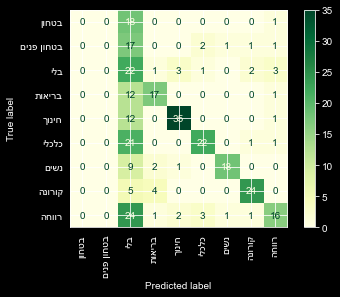

In [114]:
evaluate("-------Logistic Regression TFIDF counts, C=0.5) Evaluation-------",y_test,logistic_c05_tfidf_predicted,mat_tags)
get_confused_samples(quotes,logistic_c05_tfidf_predicted)

## Random forest

-----Random forest with simple counts, 100 trees, max depth 200) Evaluation-----
Micro:
precision: 0.5179153094462541
recall: 0.5179153094462541
f1: 0.5179153094462541

Macro:
precision: 0.7459442775867897
recall: 0.5108194518282237
f1: 0.539450198329339

Accuracy: 0.5179153094462541

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 114 of 148 (77.02702702702703%)

Distribution of misclassified topics:
בלי           114
בריאות         11
חינוך           7
כלכלי           6
קורונה          4
רווחה           3
נשים            2
בטחון פנים      1
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
2,2,כשאני מסתכל הכסף שמגיע עבור חייל בודד סיבה תשכ...,בטחון,בלי
4,4,המוסדות המטרה להגן עובדי רווחה שרשום מספק שירו...,רווחה,בלי
6,6,חמישי ה-8 ביולי שעליו נדון המשך תכנון משק החלב...,כלכלי,בלי
7,7,המשך מעקב הפסקת תקצוב וסגירת תוכניות ההכשרה למ...,חינוך,בלי
8,8,זימנתי המלג מתמרצים מעודדים סטודנטים ללימודי פ...,חינוך,בלי
...,...,...,...,...
300,300,במהלך הקיץ בחודשיים-שלושה האחרונים ארבעה נפגעו...,בטחון פנים,בריאות
302,302,מדינת מדינה שנמצאת תחת איום מהקשים והכבדים שיכ...,בטחון,בלי
304,304,התנהלות ימים וביקשתי מירדנה לפנות למזכיר העברו...,בלי,כלכלי
305,305,החוקה ומשפט 15 במרץ ממשיכים חדלות פירעון ושיקו...,כלכלי,בלי


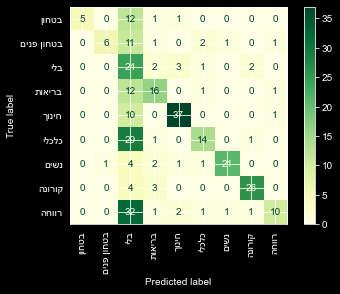

In [115]:
evaluate("-----Random forest with simple counts, 100 trees, max depth 200) Evaluation-----",y_test,forest_100_200_simple_predicted,mat_tags)
get_confused_samples(quotes,forest_100_200_simple_predicted)

-----Random forest with simple counts, 200 trees, max depth 100) Evaluation-----
Micro:
precision: 0.5602605863192183
recall: 0.5602605863192183
f1: 0.5602605863192183

Macro:
precision: 0.7293526432415322
recall: 0.549290049618997
f1: 0.5744702064571193

Accuracy: 0.5602605863192183

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 94 of 135 (69.62962962962963%)

Distribution of misclassified topics:
בלי       94
בריאות    11
חינוך     10
כלכלי      7
בטחון      5
קורונה     4
רווחה      2
נשים       2
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
4,4,המוסדות המטרה להגן עובדי רווחה שרשום מספק שירו...,רווחה,בלי
7,7,המשך מעקב הפסקת תקצוב וסגירת תוכניות ההכשרה למ...,חינוך,בלי
8,8,זימנתי המלג מתמרצים מעודדים סטודנטים ללימודי פ...,חינוך,בלי
10,10,החלק החזרת מהעודפים ממשרד האוצר נדון שדנו מבקר...,כלכלי,בלי
12,12,ביולי מזמן התמנתה ועדה גופים שתחליט מעבירים המ...,כלכלי,בטחון
...,...,...,...,...
300,300,במהלך הקיץ בחודשיים-שלושה האחרונים ארבעה נפגעו...,בטחון פנים,בריאות
302,302,מדינת מדינה שנמצאת תחת איום מהקשים והכבדים שיכ...,בטחון,בלי
304,304,התנהלות ימים וביקשתי מירדנה לפנות למזכיר העברו...,בלי,כלכלי
305,305,החוקה ומשפט 15 במרץ ממשיכים חדלות פירעון ושיקו...,כלכלי,בלי


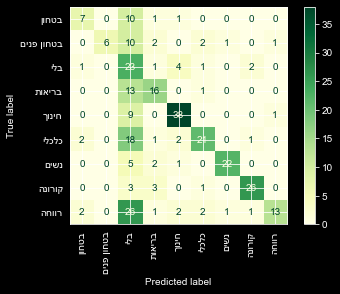

In [141]:
evaluate("-----Random forest with simple counts, 200 trees, max depth 100) Evaluation-----",y_test,forest_200_100_simple_predicted,mat_tags)
get_confused_samples(quotes,forest_200_100_simple_predicted)

In [142]:
joined = pd.concat((forest_200_100_simple_predicted, y_test), axis=1)
print(len(joined[(joined['Tag'] != joined['predicted']) & (joined['Tag'] != 'בלי')& (joined['predicted'] != 'בלי')]))
print(len(joined[(joined['Tag'] != joined['predicted']) & (joined['Tag'] != 'בלי')]))
print(len(joined[(joined['Tag'] != joined['predicted']) & (joined['predicted'] == 'בלי')]))

32
126
94


In [145]:
for tag in mat_tags:
    print(tag,len(joined[(joined['Tag'] != joined['predicted']) & (joined['Tag'] == tag)& (joined['predicted'] != "בלי")]))

בטחון 2
בטחון פנים 6
בלי 9
בריאות 1
חינוך 1
כלכלי 6
נשים 3
קורונה 4
רווחה 9


-----Random forest with simple counts, 100 trees, max depth 1000) Evaluation-----
Micro:
precision: 0.4755700325732899
recall: 0.4755700325732899
f1: 0.4755700325732899

Macro:
precision: 0.707288081005931
recall: 0.46635617874652957
f1: 0.49725775796977373

Accuracy: 0.4755700325732899

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 126 of 161 (78.26086956521739%)

Distribution of misclassified topics:
בלי           126
בריאות         15
חינוך           7
כלכלי           4
בטחון           3
רווחה           2
נשים            2
קורונה          1
בטחון פנים      1
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
2,2,כשאני מסתכל הכסף שמגיע עבור חייל בודד סיבה תשכ...,בטחון,בלי
4,4,המוסדות המטרה להגן עובדי רווחה שרשום מספק שירו...,רווחה,בלי
6,6,חמישי ה-8 ביולי שעליו נדון המשך תכנון משק החלב...,כלכלי,בלי
7,7,המשך מעקב הפסקת תקצוב וסגירת תוכניות ההכשרה למ...,חינוך,בלי
8,8,זימנתי המלג מתמרצים מעודדים סטודנטים ללימודי פ...,חינוך,בלי
...,...,...,...,...
300,300,במהלך הקיץ בחודשיים-שלושה האחרונים ארבעה נפגעו...,בטחון פנים,בריאות
302,302,מדינת מדינה שנמצאת תחת איום מהקשים והכבדים שיכ...,בטחון,בלי
304,304,התנהלות ימים וביקשתי מירדנה לפנות למזכיר העברו...,בלי,כלכלי
305,305,החוקה ומשפט 15 במרץ ממשיכים חדלות פירעון ושיקו...,כלכלי,בלי


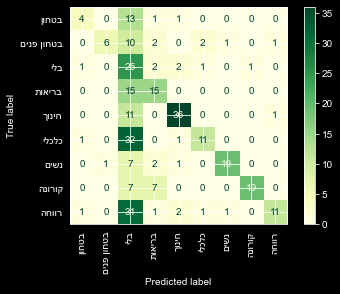

In [116]:
evaluate("-----Random forest with simple counts, 100 trees, max depth 1000) Evaluation-----",y_test,forest_100_1000_simple_predicted,mat_tags)
get_confused_samples(quotes,forest_100_1000_simple_predicted)

-----Random forest with simple counts, 150 trees, max depth 1000) Evaluation-----
Micro:
precision: 0.495114006514658
recall: 0.495114006514658
f1: 0.495114006514658

Macro:
precision: 0.74009694009694
recall: 0.48630345856223056
f1: 0.5173197948536508

Accuracy: 0.495114006514658

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 125 of 155 (80.64516129032258%)

Distribution of misclassified topics:
בלי           125
בריאות         10
חינוך           7
קורונה          4
כלכלי           4
רווחה           2
בטחון פנים      1
נשים            1
בטחון           1
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
2,2,כשאני מסתכל הכסף שמגיע עבור חייל בודד סיבה תשכ...,בטחון,בלי
4,4,המוסדות המטרה להגן עובדי רווחה שרשום מספק שירו...,רווחה,בלי
6,6,חמישי ה-8 ביולי שעליו נדון המשך תכנון משק החלב...,כלכלי,בלי
7,7,המשך מעקב הפסקת תקצוב וסגירת תוכניות ההכשרה למ...,חינוך,בלי
8,8,זימנתי המלג מתמרצים מעודדים סטודנטים ללימודי פ...,חינוך,בלי
...,...,...,...,...
299,299,נוסף שהגיע לפתחה שאנשים שחלו בקורונה בישראל פג...,קורונה,בלי
300,300,במהלך הקיץ בחודשיים-שלושה האחרונים ארבעה נפגעו...,בטחון פנים,בלי
302,302,מדינת מדינה שנמצאת תחת איום מהקשים והכבדים שיכ...,בטחון,בלי
305,305,החוקה ומשפט 15 במרץ ממשיכים חדלות פירעון ושיקו...,כלכלי,בלי


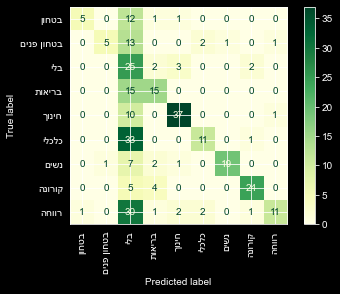

In [117]:
evaluate("-----Random forest with simple counts, 150 trees, max depth 1000) Evaluation-----",y_test,forest_150_1000_simple_predicted,mat_tags)
get_confused_samples(quotes,forest_150_1000_simple_predicted)

-----Random forest with TFIDF counts, 100 trees, max depth 200) Evaluation-----
Micro:
precision: 0.5407166123778502
recall: 0.5407166123778502
f1: 0.5407166123778502

Macro:
precision: 0.6919740478671828
recall: 0.532922795203497
f1: 0.5600700228004437

Accuracy: 0.5407166123778502

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 94 of 141 (66.66666666666666%)

Distribution of misclassified topics:
בלי           94
בריאות        14
חינוך          9
כלכלי          7
רווחה          6
בטחון          5
קורונה         3
נשים           2
בטחון פנים     1
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
4,4,המוסדות המטרה להגן עובדי רווחה שרשום מספק שירו...,רווחה,בלי
6,6,חמישי ה-8 ביולי שעליו נדון המשך תכנון משק החלב...,כלכלי,בלי
7,7,המשך מעקב הפסקת תקצוב וסגירת תוכניות ההכשרה למ...,חינוך,בלי
8,8,זימנתי המלג מתמרצים מעודדים סטודנטים ללימודי פ...,חינוך,בלי
9,9,סוד הולכים ומדברים ויותר הצורך בתקופה לשמור או...,קורונה,בריאות
...,...,...,...,...
299,299,נוסף שהגיע לפתחה שאנשים שחלו בקורונה בישראל פג...,קורונה,בלי
300,300,במהלך הקיץ בחודשיים-שלושה האחרונים ארבעה נפגעו...,בטחון פנים,בריאות
302,302,מדינת מדינה שנמצאת תחת איום מהקשים והכבדים שיכ...,בטחון,בלי
304,304,התנהלות ימים וביקשתי מירדנה לפנות למזכיר העברו...,בלי,כלכלי


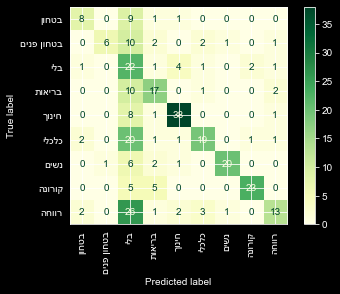

In [118]:
evaluate("-----Random forest with TFIDF counts, 100 trees, max depth 200) Evaluation-----",y_test,forest_100_200_tfidf_predicted,mat_tags)
get_confused_samples(quotes,forest_100_200_tfidf_predicted)

-----Random forest with TFIDF counts, 100 trees, max depth 1000) Evaluation-----
Micro:
precision: 0.501628664495114
recall: 0.501628664495114
f1: 0.501628664495114

Macro:
precision: 0.7283108249774917
recall: 0.49837335341721306
f1: 0.5333090066011374

Accuracy: 0.501628664495114

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 119 of 153 (77.77777777777779%)

Distribution of misclassified topics:
בלי       119
בריאות     12
חינוך       7
כלכלי       5
בטחון       3
רווחה       3
קורונה      3
נשים        1
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
4,4,המוסדות המטרה להגן עובדי רווחה שרשום מספק שירו...,רווחה,בלי
6,6,חמישי ה-8 ביולי שעליו נדון המשך תכנון משק החלב...,כלכלי,בלי
7,7,המשך מעקב הפסקת תקצוב וסגירת תוכניות ההכשרה למ...,חינוך,בלי
8,8,זימנתי המלג מתמרצים מעודדים סטודנטים ללימודי פ...,חינוך,בלי
9,9,סוד הולכים ומדברים ויותר הצורך בתקופה לשמור או...,קורונה,בריאות
...,...,...,...,...
300,300,במהלך הקיץ בחודשיים-שלושה האחרונים ארבעה נפגעו...,בטחון פנים,בריאות
302,302,מדינת מדינה שנמצאת תחת איום מהקשים והכבדים שיכ...,בטחון,בלי
304,304,התנהלות ימים וביקשתי מירדנה לפנות למזכיר העברו...,בלי,כלכלי
305,305,החוקה ומשפט 15 במרץ ממשיכים חדלות פירעון ושיקו...,כלכלי,בלי


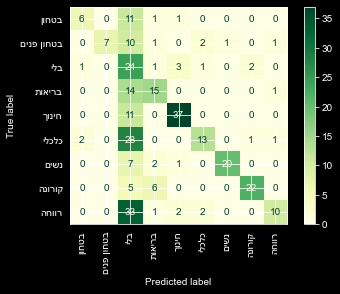

In [119]:
evaluate("-----Random forest with TFIDF counts, 100 trees, max depth 1000) Evaluation-----",y_test,forest_100_1000_tfidf_predicted,mat_tags)
get_confused_samples(quotes,forest_100_1000_tfidf_predicted)

## SVM

-----SVM with simple counts Evaluation-----
Micro:
precision: 0.36482084690553745
recall: 0.36482084690553745
f1: 0.3648208469055375

Macro:
precision: 0.5861622727819911
recall: 0.3419051627384961
f1: 0.3522319337630892

Accuracy: 0.36482084690553745

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 183 of 195 (93.84615384615384%)

Distribution of misclassified topics:
בלי       183
רווחה       8
כלכלי       2
קורונה      1
חינוך       1
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
2,2,כשאני מסתכל הכסף שמגיע עבור חייל בודד סיבה תשכ...,בטחון,בלי
4,4,המוסדות המטרה להגן עובדי רווחה שרשום מספק שירו...,רווחה,בלי
6,6,חמישי ה-8 ביולי שעליו נדון המשך תכנון משק החלב...,כלכלי,בלי
7,7,המשך מעקב הפסקת תקצוב וסגירת תוכניות ההכשרה למ...,חינוך,בלי
8,8,זימנתי המלג מתמרצים מעודדים סטודנטים ללימודי פ...,חינוך,בלי
...,...,...,...,...
300,300,במהלך הקיץ בחודשיים-שלושה האחרונים ארבעה נפגעו...,בטחון פנים,בלי
301,301,תא הלחץ דוקטור יהודה מלמד שאתמול נתן הרצאה מעל...,בריאות,בלי
302,302,מדינת מדינה שנמצאת תחת איום מהקשים והכבדים שיכ...,בטחון,בלי
305,305,החוקה ומשפט 15 במרץ ממשיכים חדלות פירעון ושיקו...,כלכלי,בלי


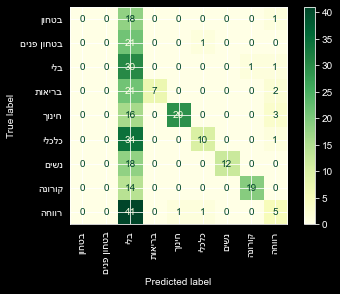

In [120]:
evaluate("-----SVM with simple counts Evaluation-----",y_test, svm_simple_predicted,mat_tags)
get_confused_samples(quotes,svm_simple_predicted)

-----SVM with TFIDF counts Evaluation-----
Micro:
precision: 0.4234527687296417
recall: 0.4234527687296417
f1: 0.42345276872964166

Macro:
precision: 0.7068568041915234
recall: 0.39812008978675645
f1: 0.4210655542494482

Accuracy: 0.4234527687296417

Confusion Matrix:

--------- confusion analysis----------
misclassified as no topic: 163 of 177 (92.09039548022598%)

Distribution of misclassified topics:
בלי       163
בריאות      6
חינוך       3
כלכלי       2
קורונה      1
נשים        1
רווחה       1
Name: predicted, dtype: int64


,index,NonStopwordsQuoteText,true,predicted
2,2,כשאני מסתכל הכסף שמגיע עבור חייל בודד סיבה תשכ...,בטחון,בלי
4,4,המוסדות המטרה להגן עובדי רווחה שרשום מספק שירו...,רווחה,בלי
6,6,חמישי ה-8 ביולי שעליו נדון המשך תכנון משק החלב...,כלכלי,בלי
7,7,המשך מעקב הפסקת תקצוב וסגירת תוכניות ההכשרה למ...,חינוך,בלי
8,8,זימנתי המלג מתמרצים מעודדים סטודנטים ללימודי פ...,חינוך,בלי
...,...,...,...,...
299,299,נוסף שהגיע לפתחה שאנשים שחלו בקורונה בישראל פג...,קורונה,בלי
300,300,במהלך הקיץ בחודשיים-שלושה האחרונים ארבעה נפגעו...,בטחון פנים,בלי
301,301,תא הלחץ דוקטור יהודה מלמד שאתמול נתן הרצאה מעל...,בריאות,בלי
302,302,מדינת מדינה שנמצאת תחת איום מהקשים והכבדים שיכ...,בטחון,בלי


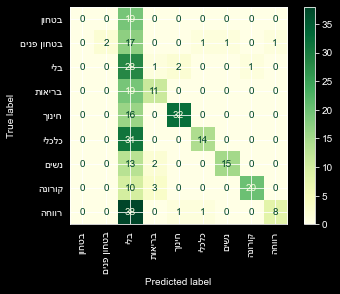

In [121]:
evaluate("-----SVM with TFIDF counts Evaluation-----",y_test, svm_tfidf_predicted,mat_tags)
get_confused_samples(quotes,svm_tfidf_predicted)

## Analysis of chosen model

-------Logistic Regression simple counts, C=2) Evaluation-------
Micro:
precision: 0.5407166123778502
recall: 0.5407166123778502
f1: 0.5407166123778502

Macro:
precision: 0.7685695570507972
recall: 0.517693750369189
f1: 0.5645922634758783

Accuracy: 0.5407166123778502

Confusion Matrix:


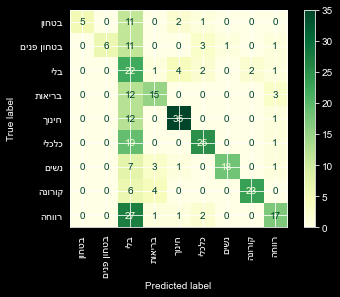

In [122]:
evaluate("-------Logistic Regression simple counts, C=2) Evaluation-------", y_test, logistic_c2_simple_predicted,
         mat_tags)

In [123]:
print(classification_report(y_test, logistic_c2_simple_predicted))

              precision    recall  f1-score   support

       בטחון       1.00      0.26      0.42        19
  בטחון פנים       1.00      0.27      0.43        22
         בלי       0.17      0.69      0.28        32
      בריאות       0.62      0.50      0.56        30
       חינוך       0.81      0.73      0.77        48
       כלכלי       0.76      0.56      0.64        45
        נשים       0.95      0.60      0.73        30
      קורונה       0.92      0.70      0.79        33
       רווחה       0.68      0.35      0.47        48

    accuracy                           0.54       307
   macro avg       0.77      0.52      0.56       307
weighted avg       0.75      0.54      0.58       307



In [124]:
confused = get_confused_samples(quotes, logistic_simple_predicted)
confused.drop(columns=['index'],inplace=True)


--------- confusion analysis----------
misclassified as no topic: 106 of 142 (74.64788732394366%)

Distribution of misclassified topics:
בלי       106
בריאות      9
כלכלי       9
רווחה       8
חינוך       7
קורונה      2
נשים        1
Name: predicted, dtype: int64


In [126]:
group = confused.groupby(['true','predicted']).count()
group.reset_index( inplace=True)
group = group[group['predicted'] != "בלי"]
group.rename(columns={'NonStopwordsQuoteText':'count'},inplace=True)
group.sort_values(by=['count'],ascending=False,inplace=True)
group

,true,predicted,count
23,קורונה,בריאות,4
13,בריאות,רווחה,3
9,בלי,כלכלי,3
4,בטחון פנים,כלכלי,3
19,נשים,בריאות,3
8,בלי,חינוך,3
10,בלי,קורונה,2
1,בטחון,חינוך,2
27,רווחה,כלכלי,2
7,בלי,בריאות,1


In [127]:
for q in confused[(confused['true'] == 'קורונה') & (confused['predicted'] == 'בריאות')]['NonStopwordsQuoteText']:
    print(q)
    print()

סוד הולכים ומדברים ויותר הצורך בתקופה לשמור אוכלוסיות בסיכון ולאפשר לאחרים חופש ותנועה שבתוך החיבוק הכול מפספסים משמעותי שאסור לחבק חיבוק דב תקופה ארוכה האירוע יכולים לבודד הקשישים לאורך לגזור עליהם בדידות מרכיב עבור הגיל לקורונה וכמה בתקופת הקורונה שנמקים בבתיהם שמתו והגופות הגיעו למצב מצאו בזמן סליחה הבוקר התיאור שמתים לבדם החולים זוכים שהמשפחה לידם ברגעים הקשים

ברשותכם פותחת נתוני התחלואה ומדיניות הבדיקות המטרה לבחון נתוני התחלואה להיום להבין לעומק שמזה תקופה ארוכה מרחף מעלינו איום הסגר הכללי בטענה במציאות אפידמיולוגית שמצריכה ככל שצללנו לנתונים ראינו פניו שמבחינת המגמות החולים הקשים המאושפזים ושל המונשמים שינויים כלשהם דרמטיים המספר יציב במשך רב העלייה עלייה ביחס לכמות המאומתים להעיד המגפה

מבין שישנם נתונים שמצביעים ירידה בכיסוי החיסוני תינוקות ותיכף נתונים בתחילת המשבר בחודש אפריל בירידה כ-30% בהשוואה לאפריל תיכף מגמת הירידה בכיסוי החיסוני נמשכת נבלמה נקווה שנשמע בשורות טובות מעוניינים תמונת המצב משתקפת מהארגונים שמלווים הסוגיה וכמובן מצדו הבריאות וגורמי המקצוע

איתנו שלושה דברי

In [128]:
for q in confused[(confused['true'] == 'נשים') & (confused['predicted'] == 'רווחה')]['NonStopwordsQuoteText']:
    print(q)
    print()

שיחה מעניינת רונית ארי שמאוד פעילה בתחום ומפעילה רות בצפון והיא שמה זרקור נערות וצעירות בסיכון הפערים פערים בחקיקה לעומת נערים נשארים בטיפול לעומת נערות אופי הטיפול הנושאים היותר חשובים לעסוק בהם בגיל הצעיר אמרתי אקח ולראשונה נקים משנה שתעסוק בנערות וצעירות בסיכון המשמעות צעירות 25 יוכל להיכנס לתוך המסגרת החוקית רצף



In [129]:
for q in confused[(confused['true'] == 'בלי') & (confused['predicted'] == 'חינוך')]['NonStopwordsQuoteText']:
    print(q)
    print()

רבותיי מילות פתיחה מתחילת הקדנציה משמש כיור החינוך נמנעתי מלכנס מוסדות תורניים כדרכנו בקודש שומרי תורה ומצוות בהשתדלות פנה פונים פנה מטפלים משתדלים בודקים

ארצה הפנים הקודם והוזמן כלאחר וממשרד הבריאות נרצה שעוד העביר משטרה הגורמים שטרם העבירו בהמשך להתכתבות נרצה לבדוק החינוך הרווחה נרצה

בהזדמנות להודות ולציין שיתוף הפעולה המדע והטכנולוגיה לוועדת המדע והטכנולוגיה באותו שיתוף פעולה ורואים המדיניות עין בעין הדברים החשובים שחשובים לוועדה במגוון הנושאים בתחום מחקר בתחום המדענים בתחום הפעילות החשיפה שמתם בהחלט בדגשים עידוד מצויינות הנגשת המידע המדע בדגש פריפריה גאוגרפית חברתית קידום אוכלוסיות מועדפות שיתוף הפעולה הרשויות המקומיות והתמיכה הגדולה במרכזי מחקר המדענים המשרדים דיברנו שצריך לקדם הנושאים פרויקט להבה צמצום פערים חשיבות שמים דגשים בתחום החינוך שנעשתה פעולה מהדגשים הדגשים חושבים שבאמת לציין השיתוף פעולה

